In [35]:
import numpy as np
import matplotlib.pyplot as plt
import shotToEqdsk
from scipy.interpolate import interp1d
%matplotlib notebook

In [36]:
shot = '174079'

In [37]:
import netCDF4
OMFIT_nc= netCDF4.Dataset(f'shots/{shot}/FIT.nc','r')

cqlinput = open(f'shots/{shot}/cqlinput','r+')
cqlinput.seek(0)

genray_in = open(f'shots/{shot}/genray.in','r+')
genray_in.seek(0)

eqdskName = shotToEqdsk.getEqdskName(shot)
eqdskTime = eqdskName.split('.')[1][1:]
eqdskFile = open(f'shots/{shot}/{eqdskName}','r+')
eqdskFile.seek(0)

0

In [38]:
eqdskFile.seek(0)
eqdskData = eqdskFile.readlines()
if 'b\'' in eqdskData[0]:
    original = eqdskData[0]
    segments = original.split()
    newData = f'  {segments[1][:-2]}     xx/yy/zzzz    #{shot}  {eqdskTime}ms           {segments[-3]}  {segments[-2]}  {segments[-1]}\n'
    eqdskData[0] = newData
    print(newData)
    eqdskFile.seek(0)
    eqdskFile.writelines(eqdskData)

In [39]:
rho_psi = np.sqrt(OMFIT_nc.variables["psi_n"])
n_e = np.copy(OMFIT_nc.variables["n_e"][0])
T_e = np.copy(OMFIT_nc.variables["T_e"][0])/1e3
T_i = np.copy(OMFIT_nc.variables["T_12C6"][0]/1e3)

neFunc = interp1d(rho_psi, n_e)
TeFunc = interp1d(rho_psi, T_e)
TiFunc = interp1d(rho_psi, T_i)

<IPython.core.display.Javascript object>


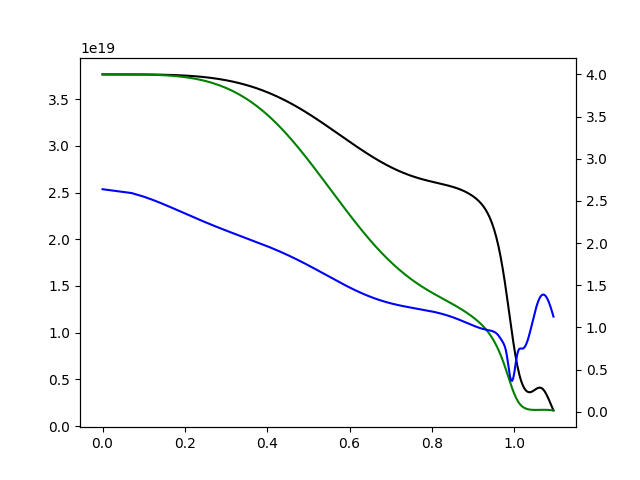

In [40]:
fig, ax = plt.subplots()
ax.plot(rho_psi, n_e, color = 'k')
ax2 = ax.twinx()
ax2.plot(rho_psi, T_e, color = 'g')
ax2.plot(rho_psi, T_i, color ='b')
fig.show()

In [41]:
ryain = np.arange(0,1.02,.02)
enein = neFunc(ryain)/1e6
Tein = TeFunc(ryain)
Tiin = TiFunc(ryain)

In [42]:
enein_str = str((np.round(enein,6)).tolist())[1:-1].replace(',','')
tein_str = str((np.round(Tein,6)).tolist())[1:-1].replace(',','')
tiin_str = str((np.round(Tiin,6)).tolist())[1:-1].replace(',','')


In [43]:
## write to cqlinput:
cqlinput.seek(0)
cqlData = cqlinput.readlines()
for i in range(len(cqlData)):
    if 'enein' in cqlData[i]:
        #print(cqlData[i])
        cqlData[i] = f' enein(1,1) = {enein_str}\n'
        
    if 'tein' in cqlData[i]:
        cqlData[i] = f' tein = {tein_str}\n'
    if 'tiin' in cqlData[i]:
        cqlData[i] = f' tiin = {tiin_str}\n'

In [44]:
cqlinput.seek(0)
cqlinput.writelines(cqlData)
cqlinput.seek(0)
cqlinput.writelines(cqlData)

In [45]:
ndens = 51
rho_gen = np.zeros(51)
for i in range(len(rho_gen)):
    rho_gen[i] = (i)/(ndens-1)
    
ne_gen = neFunc(rho_gen)
Te_gen = TeFunc(rho_gen)
Ti_gen = TiFunc(rho_gen)

dentab = np.zeros(3*ndens)
temtab = np.zeros(3*ndens)

for i in range(ndens):
    dentab[i*3] = ne_gen[i]
    dentab[i*3+1] = ne_gen[i]
    dentab[i*3+2] = ne_gen[i]
    
    temtab[i*3] = Te_gen[i]
    temtab[i*3+1] = Ti_gen[i]
    temtab[i*3+2] = Ti_gen[i]  

In [46]:
## write to cqlinput:
genray_in.seek(0)
genrayData = genray_in.readlines()
i = 0
while i < len(genrayData):
    if 'dentab\n' in genrayData[i]:
        for j in range(ndens):
            if j == 0:
                genrayData[i+j+1] = f" prof = {dentab[3*j]} {dentab[3*j+1]} {dentab[3*j+2]}\n"
            else:
                genrayData[i+j+1] = f"{dentab[3*j]} {dentab[3*j+1]} {dentab[3*j+2]}\n"
        i += ndens
    if 'temtab\n' in genrayData[i]:
        for j in range(ndens):
            if j == 0:
                genrayData[i+j+1] = f" prof = {temtab[3*j]} {temtab[3*j+1]} {temtab[3*j+2]}\n"
            else:
                genrayData[i+j+1] = f"{temtab[3*j]} {temtab[3*j+1]} {temtab[3*j+2]}\n"
        i += ndens
    i += 1
    
#cqlinput.truncate(0)
genray_in.seek(0)
genray_in.writelines(genrayData)
genray_in.seek(0)
genray_in.writelines(genrayData)

In [47]:
#for i in range(ndens):
#    print(f"{dentab[3*i]} {dentab[3*i+1]} {dentab[3*i+2]}")

In [48]:
#for i in range(ndens):
#    print(f"{temtab[3*i]} {temtab[3*i+1]} {temtab[3*i+2]}")